In [381]:
pwd()

"/home/xlx0727/Scripts/Statistic/qgplsim"

# Start

In [430]:
# run this ceil if source codes was edited
include("DGP.ji")
include("qgplsim.ji")
using Statistics, LinearAlgebra
using LaTeXStrings

import Base.Threads.@threads

# QGPLSIM fitting

In [434]:
# run this ceil for different data sets

α = [1.0, -1.0] # single index for x
θ = [-1.0, 1.0]  # linear for x, <α, θ> = 0 for identification
γ = [1.0, 0.5] # single index for z
β = [0.5, -1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 500
fx = 1 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ
ifz = true # if false, Z = 0, i.e. no category varible
X, Z, y = dgp(n, γ, θ, α, β, fx, ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha, theta, gamma, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 / alpha[1]
coefg = 1 / gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha)
println("̂γ => ", coefg * gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

theta * alpha

  3.810107 seconds (4.07 M allocations: 11.913 GiB, 37.23% gc time)
Estimation of index coefs: 
̂α => [0.9999999999999999, -0.889702918356721]
̂γ => [1.0, 0.5332032545398484]
Estimation of linear coefs: 
̂θ => [0.09027560746820518 0.10146713650770493]
̂β => [0.641345254677403, -1.0723097395908097]


1-element Vector{Float64}:
 -2.220446049250313e-16

# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

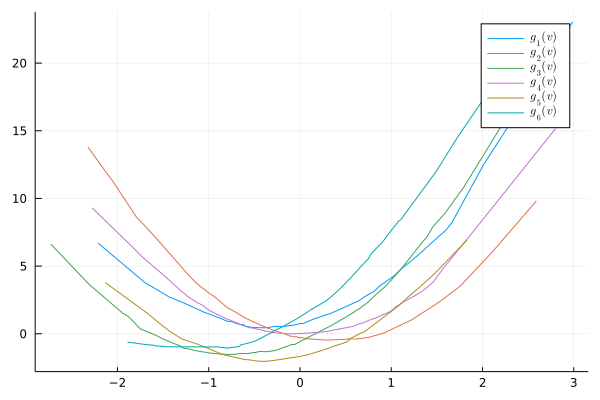

In [435]:
using Plots

v = X * alpha # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y) # g: g(v), dg: g'(v)
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(fig, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

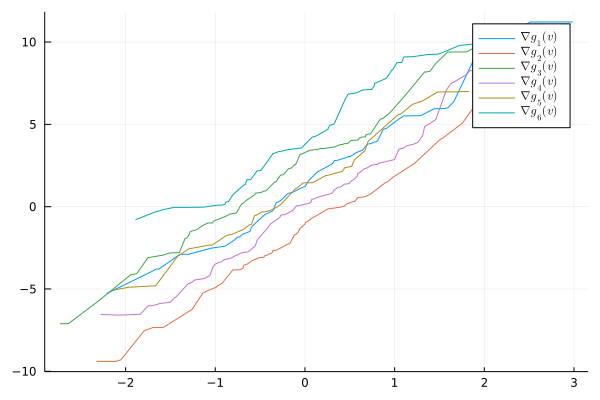

In [436]:
fig = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(fig, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
fig

# Monte Carlo Simulation

## alpha = $\alpha$

In [439]:
# Do not estimate alpha, using α instead
p = length(α)
# q = length(γ)
Theta0 = zeros(100, p)
Alpha0 = zeros(100, p)
Gamma0 = zeros(100, p)
Beta0 = zeros(100, p)
import Base.Threads.@threads
alpha_type = 1

function MonteCarlo()
    t = time()
    nthreads = 2
    len = Int(100//nthreads)
    @threads for i in 1:nthreads # parallel on threads 
            for j in 1:len # each 25
        X, Z, y = dgp(n, γ, θ, α, β)
        model_ij = qgplsim.model(X, Z, y)

        Alpha0[len*(i - 1) + j, :], Theta0[len*(i - 1) + j, :],
        Gamma0[len*(i - 1) + j, :],Beta0[len*(i - 1) + j, :] = qgplsim.estimator(model_ij, alpha_type)
        end
    end
    println("MC Computing time: ", time() - t)
    println("Alpha => ", sum(Alpha0, dims = 1))
    println("Theta => ", sum(Theta0, dims = 1))
    println("Gamma => ", sum(Gamma0, dims = 1))
    println("Beta => ", sum(Beta0, dims = 1))

    Alpha0, Theta0, Gamma0, Beta0
end
Alpha0, Theta0, Gamma0, Beta0 = MonteCarlo()
size(Alpha0)

MC Computing time: 243.34509706497192
Alpha => [6.363527392380275 -4.36963130867232]
Theta => [-19.34606001147736 20.860202409336804]
Gamma => [40.18113511670097 19.776618501881863]
Beta => [55.6510681320394 -102.16847496085029]


(100, 2)

In [137]:
var(Alpha0, dims = 1)

1×2 Matrix{Float64}:
 0.0  0.0

In [138]:
var(Theta0, dims = 1)

1×2 Matrix{Float64}:
 0.00794275  0.010815

In [139]:
var(Gamma0, dims = 1)

1×2 Matrix{Float64}:
 0.00134439  0.000220936

In [438]:
var(Beta0, dims = 1)

1×2 Matrix{Float64}:
 0.157359  0.0658517

## alpha = $ \hat{\alpha}_g $

In [140]:
p = length(α)
# q = length(γ)
Theta1 = zeros(100, p)
Alpha1 = zeros(100, p)
Gamma1 = zeros(100, p)
import Base.Threads.@threads
alpha_type = 1

function MonteCarlo()
    t = time()
    nthreads = 2
    len = Int(100//nthreads)
    @threads for i in 1:nthreads # parallel on threads 
            for j in 1:len # each 25
        X, Z, y = dgp(n, γ, θ, α, β)
        model_ij = qgplsim.model(X, Z, y)

        Alpha1[len*(i - 1) + j, :], Theta1[len*(i - 1) + j, :],Gamma1[len*(i - 1) + j, :] = qgplsim.estimator(model_ij, alpha_type)
        end
    end
    println("MC Computing time: ", time() - t)
    println("Alpha => ", sum(Alpha1, dims = 1))
    println("Theta => ", sum(Theta1, dims = 1))
    println("Gamma => ", sum(Gamma1, dims = 1))
    Alpha1, Theta1, Gamma1
end
Alpha1, Theta1, Gamma1 = MonteCarlo()
size(Alpha1)

MC Computing time: 215.3744399547577
Alpha => [-8.828159364369158 10.153695574415933]
Theta => [-33.032415870319205 27.169739914507765]
Gamma => [37.16004609142192 15.906554512492505]


(100, 2)

In [141]:
var(Alpha1, dims = 1)

1×2 Matrix{Float64}:
 0.461749  0.530065

In [142]:
var(Theta1, dims = 1)

1×2 Matrix{Float64}:
 0.317223  0.254652

In [143]:
var(Gamma1, dims = 1)

1×2 Matrix{Float64}:
 0.0183817  0.00399371

In [144]:
set_alpha, index_alpha, most_alpha = qgplsim.collection(sign.(Alpha1))
dc = index_alpha
mc = most_alpha

2-element Vector{Float64}:
 -1.0
  1.0

In [145]:
rAlpha1 = Alpha1[dc[mc], :]
rTheta1 = Theta1[dc[mc], :]
rGamma1 = Gamma1[dc[mc], :]
ns, = size(rAlpha1)

(45, 2)

In [146]:
sum(rAlpha1, dims = 1)/ns

1×2 Matrix{Float64}:
 -0.671179  0.690746

In [147]:
sum(rTheta1, dims = 1)/ns

1×2 Matrix{Float64}:
 -0.0892335  0.0961917

In [148]:
sum(rGamma1, dims = 1)/ns

1×2 Matrix{Float64}:
 0.420061  0.170417

In [149]:
var(rAlpha1, dims = 1)

1×2 Matrix{Float64}:
 0.0367361  0.0372986

In [150]:
var(rTheta1, dims = 1)

1×2 Matrix{Float64}:
 0.119331  0.124455

In [151]:
var(rGamma1, dims = 1)

1×2 Matrix{Float64}:
 0.00606476  0.00176912

## alpha = $ \hat{\alpha}_l $

In [72]:
p = length(α)
# q = length(γ)
Theta2 = zeros(100, p)
Alpha2 = zeros(100, p)
Gamma2 = zeros(100, p)
import Base.Threads.@threads
alpha_type = 2

function MonteCarlo()
    t = time()
    nthreads = 2
    len = Int(100//nthreads)
    @threads for i in 1:nthreads # parallel on threads 
            for j in 1:len # each 25
        X, Z, y = dgp(n, γ, θ, α, β)
        model_ij = qgplsim.model(X, Z, y)

        Alpha2[len*(i - 1) + j, :], Theta2[len*(i - 1) + j, :],Gamma2[len*(i - 1) + j, :] = qgplsim.estimator(model_ij, alpha_type)
        end
    end
    println("MC Computing time: ", time() - t)
    println("Alpha => ", sum(Alpha2, dims = 1))
    println("Theta => ", sum(Theta2, dims = 1))
    println("Gamma => ", sum(Gamma2, dims = 1))
    Alpha2, Theta2, Gamma2
end
Alpha2, Theta2, Gamma2 = MonteCarlo()
size(Alpha2)

MC Computing time: 243.12150979042053
Alpha => [-5.215243482083196 1.0496765718011916]
Theta => [-7.487040383682339 7.8758333632899005]
Gamma => [43.020213464243355 21.88696635495499]


(100, 2)

In [75]:
var(Gamma2, dims = 1)

1×2 Matrix{Float64}:
 0.00467511  0.000820361

In [76]:
set_alpha, index_alpha, most_alpha = qgplsim.collection(sign.(Alpha2))
dc = index_alpha
mc = most_alpha

2-element Vector{Float64}:
 -1.0
  1.0

In [77]:
rAlpha2 = Alpha2[dc[-mc], :]
rTheta2 = Theta2[dc[-mc], :]
rGamma2 = Gamma2[dc[-mc], :]
ns, = size(rAlpha2)

(47, 2)

In [78]:
sum(rAlpha2, dims = 1)/ns

1×2 Matrix{Float64}:
 0.658628  -0.680271

In [79]:
sum(rTheta2, dims = 1)/ns

1×2 Matrix{Float64}:
 -0.0748247  0.0379789

In [80]:
sum(rGamma2, dims = 1)/ns

1×2 Matrix{Float64}:
 0.432668  0.218949

In [81]:
var(rAlpha2, dims = 1)

1×2 Matrix{Float64}:
 0.00889519  0.00697901

In [82]:
var(rTheta2, dims = 1)

1×2 Matrix{Float64}:
 0.0186726  0.0124841

In [83]:
var(rGamma2, dims = 1)

1×2 Matrix{Float64}:
 0.00242054  0.00060944